In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_new as utils
import scipy.stats as stats
import scipy

%config InlineBackend.figure_format='retina'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

%load_ext autoreload
%autoreload 2

In [48]:
data_dir = ['new_data/transformed_10um/']

enzymes = utils.enzymeBayes(data_dir, ml=20)

23 files; 116 trajectories (length >= 20); Total 8442 data points


# Posterior Predictive Checks 

The p-values for PPCs are calculated as follows: 

1. Sample uniformly from $p(\theta \mid X)$ to yield $M$ samples of $\theta$. 
2. Generate $M$ instance of data according to $p(X_{\text{new, m}}\mid \theta_m)$. 
3. Compute $T(X_{\text{new, m}})$ for each data generated, and compute $T(X)$ for the observed data. 
4. $p_{bayes}$ is the proportion of M for which $T(X) \geq T(X_{\text{new, m}})$, m=1, $\cdot \cdot \cdot$, M. 

We look at three test quantities in this work: 
1. Mean square displacement at specified $\tau$: MSD$(\tau)$
2. Max displacement at specified $\tau$: $max(\bar{r})_{\tau}$
3. Time-correlation of successive displacements: $<\bar{r}_i \bar{r}_{i+1}>$

### MSD$(\tau)$
testing for confinement or drift

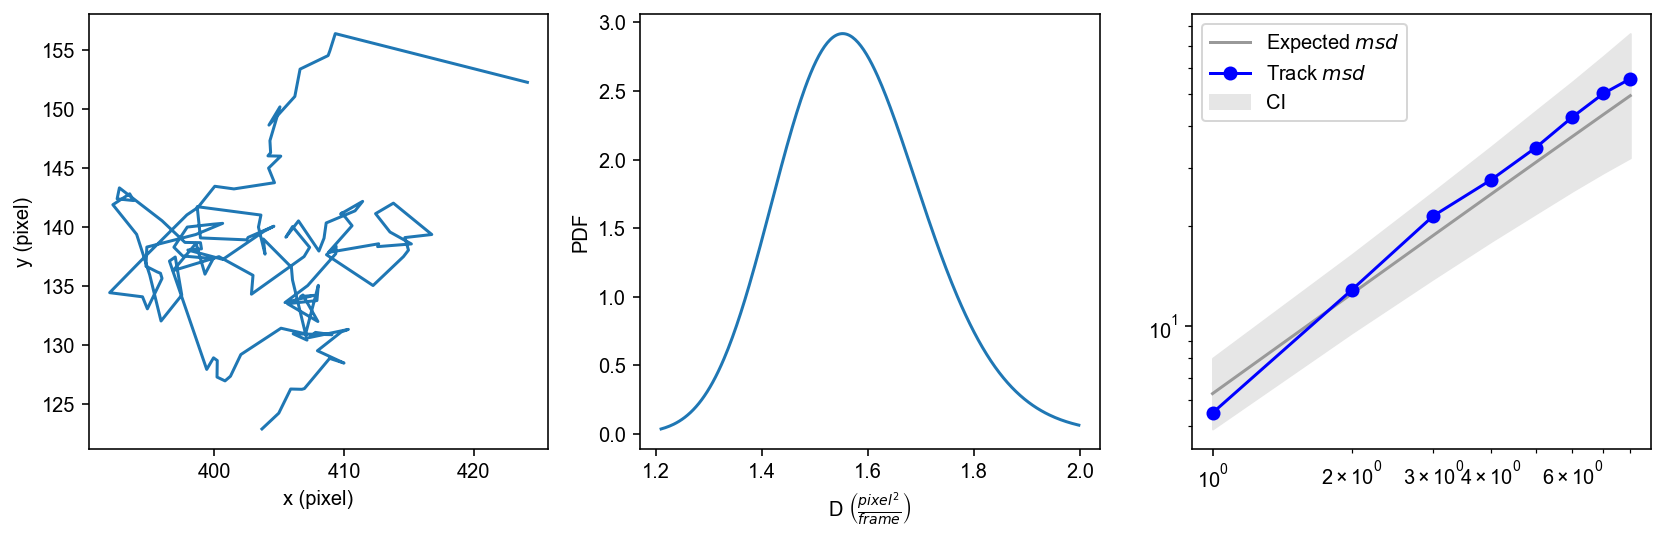

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# track
sx, sy, st = enzymes.loadSelectTraj(0, 59)
axes[0].plot(sx, sy)
axes[0].set_xlabel('x (pixel)')
axes[0].set_ylabel('y (pixel)')

# posterior
sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
a = 1 + len(sdx)
b = 1 + s

x_ = np.linspace(stats.invgamma.ppf(0.001, a=a, scale=b),
                 stats.invgamma.ppf(0.996, a=a, scale=b), 300)

axes[1].plot(x_, stats.invgamma.pdf(x_, a=a, scale=b))
axes[1].set_xlabel(r'D $\left(\frac{pixel^2}{frame}\right)$')
axes[1].set_ylabel('PDF')

# ppc and pvalue
enzyme = utils.enzymeBayes(None, loadFromCvs=False, tot_x = [sx], tot_y=[sy],
                            tot_t=[st], tot_track_info=[[len(sx)]], tot_msd=[[]], tot_msd_id=[[0]])

tau = 8
test_eval = []
for i in range(tau):
    test_eval.append(['self.tq_msd', ['sdt', str(i+1)]])

lol = enzyme.p_value_disp(0, test_eval, [0])

msds = enzyme.tot_msd[0][0][0]
means = enzyme.tot_msd[0][0][1]
stds = enzyme.tot_msd[0][0][2]
lags = np.arange(1, tau+1)


axes[2].loglog(lags, np.exp(means), '-', color='0.6', label=r'Expected $msd$')
axes[2].fill_between(lags, np.exp(means-1.96*stds), np.exp(means+1.96*stds), color='0.9', label='CI')
axes[2].loglog(lags, np.exp(msds), '-o', color='b', label=r'Track $msd$')


# axes[2].hist(tq_sim, bins=30, density=True, label='pvalue = 0')
# axes[2].axvline(x=tq_true, c='r', ls='--')
# axes[2].set_xlabel(r'MSD$(\tau=4)$')
axes[2].legend()

plt.show()

### $max(\bar{r})_{\tau}$
testing for detection error

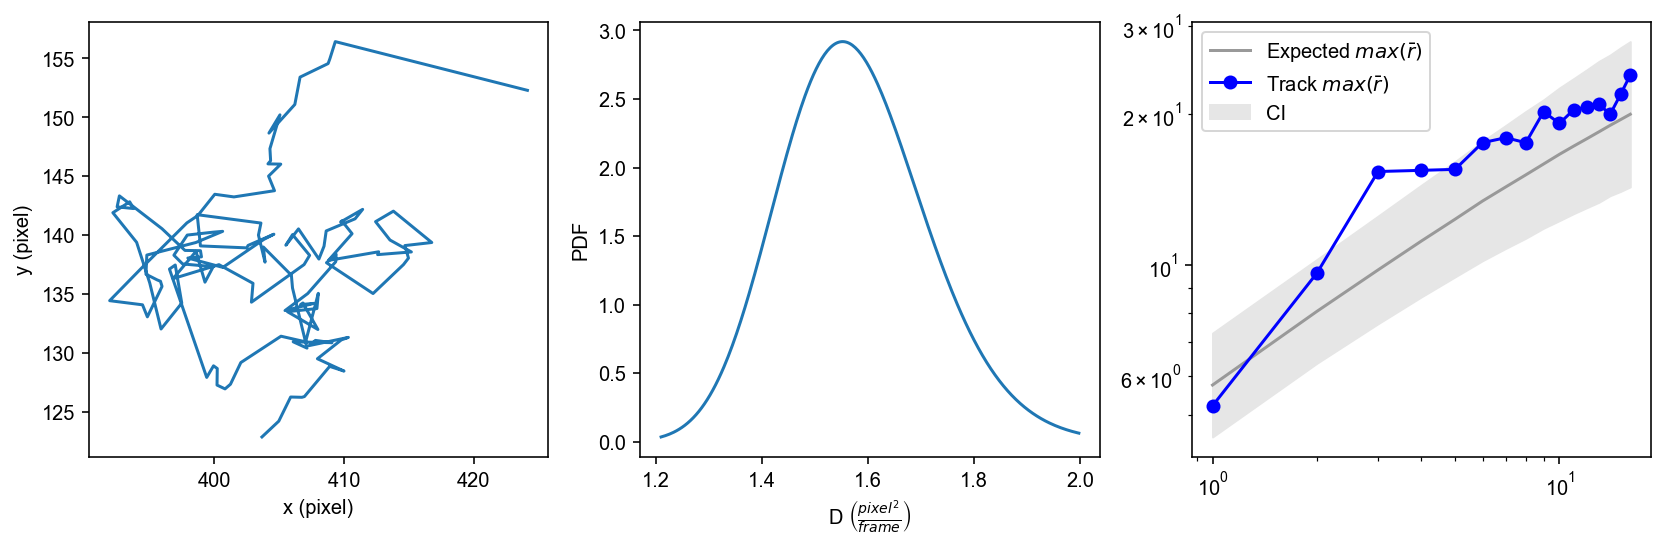

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# track
sx, sy, st = enzymes.loadSelectTraj(0, 59)
axes[0].plot(sx, sy)
axes[0].set_xlabel('x (pixel)')
axes[0].set_ylabel('y (pixel)')

# posterior
sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
a = 1 + len(sdx)
b = 1 + s

x_ = np.linspace(stats.invgamma.ppf(0.001, a=a, scale=b),
                 stats.invgamma.ppf(0.996, a=a, scale=b), 300)

axes[1].plot(x_, stats.invgamma.pdf(x_, a=a, scale=b))
axes[1].set_xlabel(r'D $\left(\frac{pixel^2}{frame}\right)$')
axes[1].set_ylabel('PDF')

# ppc and pvalue
enzyme = utils.enzymeBayes(None, loadFromCvs=False, tot_x = [sx], tot_y=[sy],
                            tot_t=[st], tot_track_info=[[len(sx)]], tot_msd=[[]], tot_msd_id=[[0]])

tau = 16
test_eval = []
for i in range(tau):
    test_eval.append(['self.tq_maxdis', ['sdt', str(i+1)]])

lol = enzyme.p_value_disp(0, test_eval, [0])

msds = enzyme.tot_msd[0][0][0]
means = enzyme.tot_msd[0][0][1]
stds = enzyme.tot_msd[0][0][2]
lags = np.arange(1, tau+1)


axes[2].loglog(lags, np.exp(means), '-', color='0.6', label=r'Expected $max(\bar{r})$')
axes[2].fill_between(lags, np.exp(means-1.96*stds), np.exp(means+1.96*stds), color='0.9', label='CI')
axes[2].loglog(lags, np.exp(msds), '-o', color='b', label=r'Track $max(\bar{r})$')


# axes[2].hist(tq_sim, bins=30, density=True, label='pvalue = 0')
# axes[2].axvline(x=tq_true, c='r', ls='--')
# axes[2].set_xlabel(r'MSD$(\tau=4)$')
axes[2].legend()

plt.show()

### $<\bar{r}_i \bar{r}_{i+1}>$
testing for ME

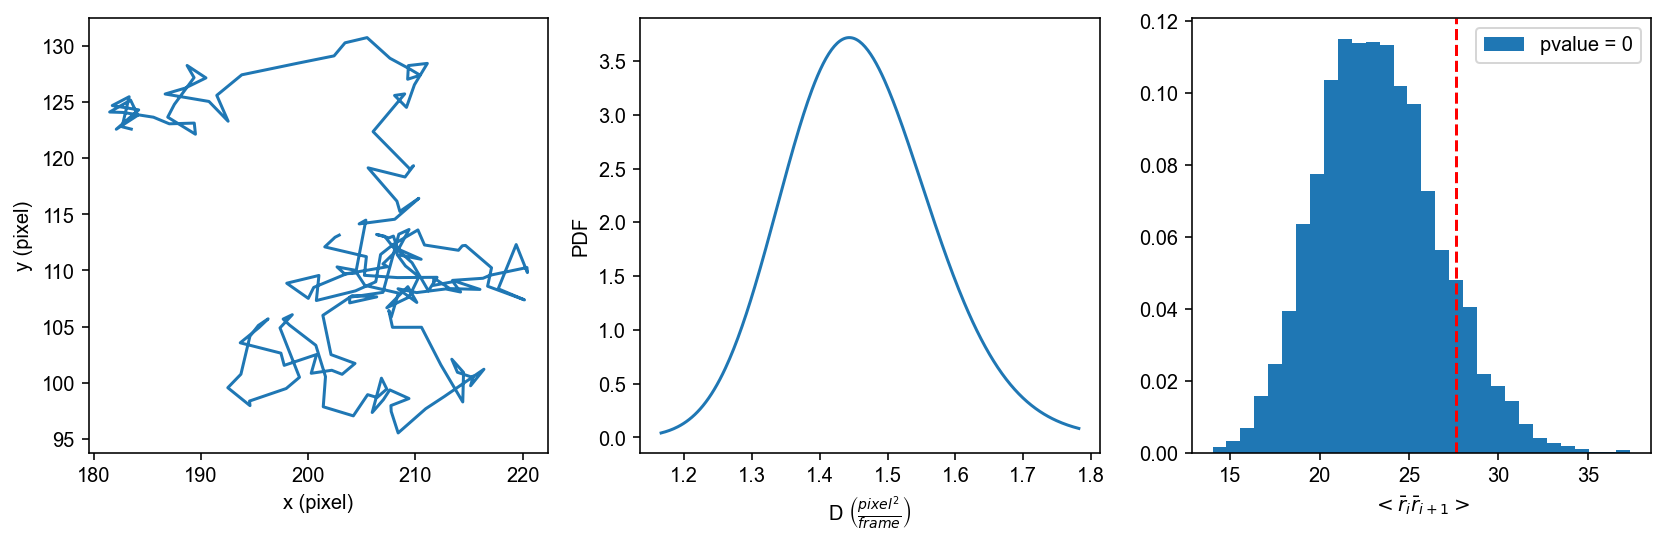

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# track
sx, sy, st = enzymes.loadSelectTraj(0, 50)
axes[0].plot(sx[:-3], sy[:-3])
axes[0].set_xlabel('x (pixel)')
axes[0].set_ylabel('y (pixel)')

# posterior
# sx, sy, st = sx[1:-3], sy[1:-3], st[1:-3]
sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
a = 1 + len(sdx)
b = 1 + s

x_ = np.linspace(stats.invgamma.ppf(0.001, a=a, scale=b),
                 stats.invgamma.ppf(0.996, a=a, scale=b), 300)

axes[1].plot(x_, stats.invgamma.pdf(x_, a=a, scale=b))
axes[1].set_xlabel(r'D $\left(\frac{pixel^2}{frame}\right)$')
axes[1].set_ylabel('PDF')

# ppc and pvalue
D_samples = stats.invgamma.rvs(a=a, scale=b, size=4000)
sim_x = (utils.base_bm_all(D_samples, int(st[-1] - st[0] + 1)))[(st - st[0]).astype(int), :]
sim_y = (utils.base_bm_all(D_samples, int(st[-1] - st[0] + 1)))[(st - st[0]).astype(int), :]
tq_sim  = enzymes.tq_msd(sim_x, sim_y, [sdt, 4])
tq_true = enzymes.tq_msd(sx, sy, [sdt, 4])

axes[2].hist(tq_sim, bins=30, density=True, label='pvalue = 0')
axes[2].axvline(x=tq_true, c='r', ls='--')
axes[2].set_xlabel(r'$<\bar{r}_i \bar{r}_{i+1}>$')
axes[2].legend()

plt.show()